In [194]:
import sys

sys.path.append('/home/michieletto/hmp_utils')
if '../' not in sys.path:
    sys.path.append('../')

In [195]:
import json
import glob
import os
import random

from hmp_utils.motion.body_models_constants import SmplConstants
from hmp_utils.motion.mocap_processor import MocapLoader
from hmp_utils.motion.kinematics import ForwardKinematics
from hmp_utils.visualize.stickman_animation import pose_animation, CameraOrientation, AnimationMode
from hmp_utils import EvaluationProtocol

from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import numpy as np
import pandas as pd
import wandb
import math
import re


In [196]:
wandb.login()

True

In [197]:

directory = '/home/michieletto/datasets/AMASS_H/KIT'
file_paths = glob.glob(directory + '/**/*.npz', recursive=True)

file_paths = sorted(file_paths)
print(len(file_paths))

occur_lab = []
deleted = []
for i,file in enumerate(file_paths):
    file_name = os.path.basename(file)    # ottiene il nome del file

    # Controlla se la stringa inizia con una lettera
    if re.match(r'^[a-zA-Z]', file_name):
        # Estrarre la parte della stringa fino al primo numero
        match = re.match(r'^[^\d]+', file_name)
        if match:
            result = match.group()

        # Sostituire gli underscore con spazi vuoti
        result = result.replace('_', ' ')
        result = re.sub(r'(?<!^)(?=[A-Z])', ' ', result)

        occur_lab.append(result)
    else:
        deleted.append(i)

print(len(occur_lab))

for i in sorted(deleted, reverse=True):
    del file_paths[i]

print(len(file_paths))


4232
4200
4200


In [198]:
# -- load mocap --
mocap_loader=MocapLoader(body_model_type=SmplConstants.BODY_MODEL_TYPE,
                         keypoint_ids_to_load=SmplConstants.KEYPOINTS,
                         target_framerate = 25)

motions = []
motions = [mocap_loader.load_mocap(path) for path in file_paths]     # lista delle classi di tutti i mocap

In [199]:
bodyConstants = SmplConstants

fk_processor = ForwardKinematics(bodyConstants.OFFSETS, bodyConstants.PARENTS)
fk_processor.set_body_model_type(bodyConstants.BODY_MODEL_TYPE)
fk_processor.normalize_joints(reference_joint=bodyConstants.JOINT_TO_NORMALIZE)

metrics_dict, metric_processor_dict = EvaluationProtocol.initialize_metrics_dicts(fk_processor=fk_processor)

In [200]:
frame_vocab = []
deleted_paths = []
frames_to_jump = 17
cont = 0
random.seed(42)
for i in range(len(motions)):
    if motions[i] is not None:
        if len(motions[i].rots) >= 75 + frames_to_jump:
            rand_x = random.randint(0, len(motions[i].rots) - 75)
            frame_vocab.append(motions[i].rots[rand_x:rand_x + 75])
            assert len(frame_vocab[-1]) == 75

            frame_vocab[-1] = [[angle for k_point in frame for angle in k_point] for frame in frame_vocab[-1]]
            assert len(frame_vocab[-1][0]) == 72
        else:
            frame_vocab.append([])
            deleted_paths.append(i)
            cont +=1
    else:
        frame_vocab.append([])
        deleted_paths.append(i)
        cont += 1

sum = 0
for i in range(len(frame_vocab)):
    sum += len(frame_vocab[i])

print(f"Numero di mocap non validi: {cont}")
print(f"Il numero totale di frame è: {sum}")


Numero di mocap non validi: 256
Il numero totale di frame è: 295800


In [201]:
dataset = {
    'pose': [],
    'description': [],
}

for i in range(len(occur_lab)):
    if i not in deleted_paths:
        dataset["pose"].append(frame_vocab[i])
        dataset["description"].append(occur_lab[i])

print(len(dataset['pose']), len(dataset['description']))

frame_vocab = pd.DataFrame(dataset["pose"])
frame_vocab_copy = frame_vocab.copy()

print(len(frame_vocab))


3944 3944
3944


In [202]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 72
75 72


In [203]:
# # Funzione per eliminare una colonna da ogni matrice
# def elimina_colonna(matrice, indexes_to_exclude):

#     return [np.delete(row, indexes_to_exclude) for row in matrice]

# indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23
# # Applica la funzione a ogni elemento del DataFrame
# frame_vocab = frame_vocab.apply(elimina_colonna, indexes_to_exclude = indexes_to_exclude)

In [204]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 72
75 72


In [205]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# train_data, test_data = train_test_split(frame_vocab, test_size=0.2, random_state=RANDOM_SEED)
# valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

# print(len(train_data), len(valid_data), len(test_data))


In [206]:
def get_collate_fn():
    def collate_fn(batch):
        batch = [[row[i] for row in batch] for i in range(len(batch[0]))]
        batch = np.array(batch)
        batch = torch.tensor(batch)
        batch = batch.float()
        
        return batch

    return collate_fn

In [207]:
def get_data_loader(dataset, batch_size, shuffle=True):
    collate_fn = get_collate_fn()
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [208]:
batch_size = 64

# train_data_loader = get_data_loader(train_data.values.tolist(), batch_size, shuffle=True)
# valid_data_loader = get_data_loader(valid_data.values.tolist(), batch_size)
# test_data_loader = get_data_loader(test_data.values.tolist(), batch_size)


# batch = next(iter(train_data_loader))
# print(type(batch), len(batch))
# print(type(batch[0]), len(batch[0]))
# print(type(batch[0][0]), len(batch[0][0]))


In [209]:
class Encoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, src):
        
        # src = [src length, batch size, dense_vector_dim]
        outputs, (hidden, cell) = self.rnn(src)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [210]:
class Decoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = dense_vector_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, dense_vector_dim)

    def forward(self, input, hidden, cell):
        # input = [batch size, dense_vector_dim]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size, dense_vector_dim]
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        input = input.squeeze(0)
        prediction = input + prediction
        
        return prediction, hidden, cell

In [211]:
def position_embedding(d_model, max_len=75):  # +25*4
    if d_model <= 0:
        pe = torch.eye(max_len).float()
        pe.require_grad = False
        return pe

    pe = torch.zeros(max_len, d_model).float()
    pe.require_grad = False

    position = torch.arange(0, max_len).float().unsqueeze(1)
    div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [224]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.linear = nn.Linear(144, 72)
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = 72
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        pos_embedding = position_embedding(d_model=72)
        pos_emb = pos_embedding[0 : src.size(0)].unsqueeze(1).repeat(1, src.size(1), 1).to(self.device)
        input_cur = torch.cat((src, pos_emb), dim=-1)

        hidden, cell = self.encoder(input_cur)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        input = src[-1, :]
        count = src.size(0)
        # input = [batch size, output_dim]
        for t in range(trg_length):
            pos_emb = pos_embedding[count - 1 : count].repeat(input.size(0), 1).to(self.device)
            input = torch.cat((input, pos_emb), dim=-1)
            count +=1
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            output = self.linear(output)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # outputs = [trg_lenght, batch_size, dense_vector_dim]
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else output
            # input = [batch size]
        
        return outputs

In [225]:

dense_vector_encoder_dim = 72*2 
dense_vector_decoder_dim = 72*2 
hidden_dim = [1024]
lr = [0.001]
n_layers = [3]
encoder_dropout = 0
decoder_dropout = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder = Encoder(
#     dense_vector_encoder_dim,
#     hidden_dim[0],
#     n_layers[0],
#     encoder_dropout,
# )

# decoder = Decoder(
#     dense_vector_decoder_dim,
#     hidden_dim[0],
#     n_layers[0],
#     decoder_dropout,
# )

# model = Seq2Seq(encoder, decoder, device).to(device)

In [226]:
# Number of iterations
EPOCHS = 300

# Optimizer Adam
# optimizer = optim.Adam(model.parameters(), lr=2e-5)

# total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [227]:
def train_fn(
    model, data_loader, optimizer, scheduler, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    num_mocap = 0
    for i, batch in enumerate(data_loader):
        src_lenght = 50
        trg_lenght = 25

        src = batch[:src_lenght].to(device)
        trg = batch[-trg_lenght:].to(device)
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, dense_vector_dim]
        output_dim = output.shape[-1]
        output = output[:].view(-1, output_dim)
        # output = [trg length * batch size, dense_vector_dim]
        trg = trg[:].view(-1, output_dim)
        # trg = [trg length * batch size, dense_vector_dim]
        loss = torch.square(output - trg)
        loss = torch.sum(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()  
        num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [228]:
def evaluate_fn(model, data_loader, device):
    model.eval()
    epoch_loss = 0
    num_mocap = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src_lenght = 50
            trg_lenght = 25

            src = batch[:src_lenght].to(device)
            trg = batch[-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[:].view(-1, output_dim)
            # output = [trg length * batch size, trg vocab size]
            trg = trg[:].view(-1, output_dim)
            # trg = [trg length * batch size]
            loss = torch.square(output - trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [229]:
clip = 1.0
teacher_forcing_ratio = 0

best_valid_loss = float("inf")
history = {
    "train_loss": [],
    "valid_loss": [],
    "losses": []
}

train_data, test_data = train_test_split(frame_vocab, test_size=0.2, random_state=RANDOM_SEED)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

train_data_loader = get_data_loader(train_data.values.tolist(), batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data.values.tolist(), batch_size)
test_data_loader = get_data_loader(test_data.values.tolist(), batch_size)

all_seeds = [434345, 434345, 232, 875434, 3232356, 42, 645332, 67789, 3426, 2354]
for i in range(len(hidden_dim)):
    for j in range(len(lr)):
        for k in range(len(n_layers )):
            # dataset = dataset.sample(frac=1).reset_index(drop=True)
            print("Parametri utilizzati:")
            print("Hidden size encoder:", hidden_dim[i])
            print("Learning rate:", lr[j])
            print("Num layers:", n_layers[k])

            # run = wandb.init(
            #     # Set the project where this run will be logged
            #     project="without_description_second_version_plot",

            #     name=f"{hidden_dim[i]}_{lr[j]}_{n_layers[k]}",
            #     # Track hyperparameters and run metadata
            #     config={
            #         "hidden_size_encoder": hidden_dim[i],
            #         "learning_rate": lr[j],
            #         "num_layers": n_layers[k],
            #     },
            # )

            torch.manual_seed(RANDOM_SEED)

            encoder = Encoder(
            dense_vector_encoder_dim,
            hidden_dim[i],
            n_layers[k],
            encoder_dropout,
            )

            decoder = Decoder(
                dense_vector_decoder_dim,
                hidden_dim[i],
                n_layers[k],
                decoder_dropout,
            )

            model = Seq2Seq(encoder, decoder, device).to(device)
            optimizer = optim.Adam(model.parameters(), lr[j])

            total_steps = len(train_data_loader) * EPOCHS

            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=total_steps
            )
            
            for epoch in tqdm.tqdm(range(EPOCHS)):
                train_loss = train_fn(
                    model,
                    train_data_loader,
                    optimizer,
                    scheduler,
                    clip,
                    teacher_forcing_ratio,
                    device,
                )
                history["train_loss"].append(train_loss)

                valid_loss = evaluate_fn(
                    model,
                    valid_data_loader,
                    device,
                )
                history["valid_loss"].append(valid_loss)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), "dataset_ridotto_seconda_versione.pt")
                print(f"\tTrain Loss: {train_loss:7.3f}")
                print(f"\tValid Loss: {valid_loss:7.3f}")

                # wandb.log({"validation error": valid_loss, "train error": train_loss})

            history["losses"].append(best_valid_loss)
            # print(f"Epoch {i+1}/10")
            print(best_valid_loss)
            best_valid_loss = float("inf")

Parametri utilizzati:
Hidden size encoder: 1024
Learning rate: 0.001
Num layers: 3


  0%|          | 1/300 [00:12<1:02:43, 12.59s/it]

	Train Loss: 152.890
	Valid Loss:  72.897


  1%|          | 2/300 [00:25<1:02:49, 12.65s/it]

	Train Loss:  67.390
	Valid Loss:  58.440


  1%|          | 3/300 [00:37<1:02:33, 12.64s/it]

	Train Loss:  61.089
	Valid Loss:  52.643


  1%|▏         | 4/300 [00:50<1:02:25, 12.65s/it]

	Train Loss:  52.083
	Valid Loss:  48.426


  2%|▏         | 5/300 [01:03<1:02:09, 12.64s/it]

	Train Loss:  47.395
	Valid Loss:  42.536


  2%|▏         | 6/300 [01:15<1:01:34, 12.56s/it]

	Train Loss:  43.953
	Valid Loss:  41.788


  2%|▏         | 7/300 [01:27<1:00:42, 12.43s/it]

	Train Loss:  41.716
	Valid Loss:  38.339


  3%|▎         | 8/300 [01:39<1:00:05, 12.35s/it]

	Train Loss:  39.818
	Valid Loss:  37.447


  3%|▎         | 9/300 [01:52<59:46, 12.32s/it]  

	Train Loss:  36.754
	Valid Loss:  33.799


  3%|▎         | 10/300 [02:04<59:47, 12.37s/it]

	Train Loss:  34.280
	Valid Loss:  32.440


  4%|▎         | 11/300 [02:16<59:24, 12.34s/it]

	Train Loss:  31.958
	Valid Loss:  30.254


  4%|▍         | 12/300 [02:29<59:08, 12.32s/it]

	Train Loss:  29.991
	Valid Loss:  28.612


  4%|▍         | 13/300 [02:41<59:01, 12.34s/it]

	Train Loss:  28.878
	Valid Loss:  28.160


  5%|▍         | 14/300 [02:53<58:43, 12.32s/it]

	Train Loss:  27.078
	Valid Loss:  27.201


  5%|▌         | 15/300 [03:06<58:38, 12.35s/it]

	Train Loss:  25.621
	Valid Loss:  26.111


  5%|▌         | 16/300 [03:18<58:13, 12.30s/it]

	Train Loss:  24.353
	Valid Loss:  24.854


  6%|▌         | 17/300 [03:31<58:30, 12.40s/it]

	Train Loss:  23.647
	Valid Loss:  23.862


  6%|▌         | 18/300 [03:43<58:30, 12.45s/it]

	Train Loss:  21.679
	Valid Loss:  22.589


  6%|▋         | 19/300 [03:56<58:38, 12.52s/it]

	Train Loss:  20.757
	Valid Loss:  22.182


  7%|▋         | 20/300 [04:09<58:36, 12.56s/it]

	Train Loss:  19.946
	Valid Loss:  21.569


  7%|▋         | 21/300 [04:21<58:40, 12.62s/it]

	Train Loss:  19.505
	Valid Loss:  20.179


  7%|▋         | 22/300 [04:34<58:34, 12.64s/it]

	Train Loss:  18.635
	Valid Loss:  19.720


  8%|▊         | 23/300 [04:45<56:11, 12.17s/it]

	Train Loss:  17.163
	Valid Loss:  19.802


  8%|▊         | 24/300 [04:58<56:47, 12.35s/it]

	Train Loss:  16.685
	Valid Loss:  18.260


  8%|▊         | 25/300 [05:10<56:46, 12.39s/it]

	Train Loss:  15.831
	Valid Loss:  18.026


  9%|▊         | 26/300 [05:21<54:07, 11.85s/it]

	Train Loss:  15.102
	Valid Loss:  18.121


  9%|▉         | 27/300 [05:33<54:22, 11.95s/it]

	Train Loss:  14.759
	Valid Loss:  16.745


  9%|▉         | 28/300 [05:44<52:39, 11.61s/it]

	Train Loss:  14.089
	Valid Loss:  17.355


 10%|▉         | 29/300 [05:55<51:33, 11.42s/it]

	Train Loss:  13.464
	Valid Loss:  17.048


 10%|█         | 30/300 [06:08<53:03, 11.79s/it]

	Train Loss:  12.979
	Valid Loss:  16.561


 10%|█         | 31/300 [06:18<51:42, 11.53s/it]

	Train Loss:  12.232
	Valid Loss:  17.092


 11%|█         | 32/300 [06:31<53:02, 11.87s/it]

	Train Loss:  12.053
	Valid Loss:  16.350


 11%|█         | 33/300 [06:44<53:48, 12.09s/it]

	Train Loss:  11.448
	Valid Loss:  15.582


 11%|█▏        | 34/300 [06:56<54:23, 12.27s/it]

	Train Loss:  11.322
	Valid Loss:  15.021


 12%|█▏        | 35/300 [07:07<52:24, 11.87s/it]

	Train Loss:  10.655
	Valid Loss:  15.134


 12%|█▏        | 36/300 [07:18<50:59, 11.59s/it]

	Train Loss:  10.355
	Valid Loss:  15.830


 12%|█▏        | 37/300 [07:29<49:53, 11.38s/it]

	Train Loss:  10.236
	Valid Loss:  15.381


 13%|█▎        | 38/300 [07:42<51:28, 11.79s/it]

	Train Loss:   9.350
	Valid Loss:  14.777


 13%|█▎        | 39/300 [07:53<50:09, 11.53s/it]

	Train Loss:   8.659
	Valid Loss:  15.262


 13%|█▎        | 40/300 [08:04<49:09, 11.34s/it]

	Train Loss:   8.783
	Valid Loss:  15.033


 14%|█▎        | 41/300 [08:15<48:20, 11.20s/it]

	Train Loss:   8.319
	Valid Loss:  15.026


 14%|█▍        | 42/300 [08:25<47:34, 11.07s/it]

	Train Loss:   7.916
	Valid Loss:  14.943


 14%|█▍        | 43/300 [08:38<49:24, 11.53s/it]

	Train Loss:   7.561
	Valid Loss:  14.139


 15%|█▍        | 44/300 [08:50<50:26, 11.82s/it]

	Train Loss:   7.348
	Valid Loss:  13.887


 15%|█▌        | 45/300 [09:01<48:58, 11.52s/it]

	Train Loss:   6.939
	Valid Loss:  14.104


 15%|█▌        | 46/300 [09:14<50:13, 11.86s/it]

	Train Loss:   6.645
	Valid Loss:  13.849


 16%|█▌        | 47/300 [09:25<48:44, 11.56s/it]

	Train Loss:   6.359
	Valid Loss:  14.032


 16%|█▌        | 48/300 [09:38<49:59, 11.90s/it]

	Train Loss:   5.894
	Valid Loss:  13.579


 16%|█▋        | 49/300 [09:48<48:09, 11.51s/it]

	Train Loss:   5.696
	Valid Loss:  13.952


 17%|█▋        | 50/300 [09:59<46:55, 11.26s/it]

	Train Loss:   5.494
	Valid Loss:  14.334


 17%|█▋        | 51/300 [10:10<46:20, 11.17s/it]

	Train Loss:   5.582
	Valid Loss:  14.393


 17%|█▋        | 52/300 [10:20<45:29, 11.01s/it]

	Train Loss:   5.322
	Valid Loss:  13.734


 18%|█▊        | 53/300 [10:33<47:02, 11.43s/it]

	Train Loss:   5.039
	Valid Loss:  13.402


 18%|█▊        | 54/300 [10:44<46:00, 11.22s/it]

	Train Loss:   4.887
	Valid Loss:  13.756


 18%|█▊        | 55/300 [10:56<47:36, 11.66s/it]

	Train Loss:   4.515
	Valid Loss:  13.376


 19%|█▊        | 56/300 [11:07<46:10, 11.36s/it]

	Train Loss:   4.377
	Valid Loss:  13.467


 19%|█▉        | 57/300 [11:17<44:58, 11.10s/it]

	Train Loss:   4.263
	Valid Loss:  13.453


 19%|█▉        | 58/300 [11:28<44:17, 10.98s/it]

	Train Loss:   4.185
	Valid Loss:  13.562


 20%|█▉        | 59/300 [11:41<46:08, 11.49s/it]

	Train Loss:   3.964
	Valid Loss:  13.067


 20%|██        | 60/300 [11:51<44:58, 11.24s/it]

	Train Loss:   3.744
	Valid Loss:  13.514


 20%|██        | 61/300 [12:02<44:18, 11.12s/it]

	Train Loss:   3.740
	Valid Loss:  13.929


 21%|██        | 62/300 [12:13<43:48, 11.04s/it]

	Train Loss:   3.542
	Valid Loss:  13.593


 21%|██        | 63/300 [12:24<43:21, 10.98s/it]

	Train Loss:   3.408
	Valid Loss:  13.304


 21%|██▏       | 64/300 [12:35<43:12, 10.99s/it]

	Train Loss:   3.307
	Valid Loss:  13.410


 22%|██▏       | 65/300 [12:46<43:05, 11.00s/it]

	Train Loss:   3.189
	Valid Loss:  13.235


 22%|██▏       | 66/300 [12:57<42:24, 10.87s/it]

	Train Loss:   3.009
	Valid Loss:  13.282


 22%|██▏       | 67/300 [13:07<42:05, 10.84s/it]

	Train Loss:   3.074
	Valid Loss:  13.672


 23%|██▎       | 68/300 [13:18<41:50, 10.82s/it]

	Train Loss:   2.898
	Valid Loss:  13.254


 23%|██▎       | 69/300 [13:29<41:49, 10.86s/it]

	Train Loss:   2.822
	Valid Loss:  13.328


 23%|██▎       | 70/300 [13:40<41:45, 10.89s/it]

	Train Loss:   2.685
	Valid Loss:  13.366


 24%|██▎       | 71/300 [13:51<41:36, 10.90s/it]

	Train Loss:   2.554
	Valid Loss:  13.586


 24%|██▍       | 72/300 [14:04<43:27, 11.44s/it]

	Train Loss:   2.525
	Valid Loss:  13.047


 24%|██▍       | 73/300 [14:16<44:30, 11.76s/it]

	Train Loss:   2.654
	Valid Loss:  12.964


 25%|██▍       | 74/300 [14:27<43:15, 11.49s/it]

	Train Loss:   2.473
	Valid Loss:  13.282


 25%|██▌       | 75/300 [14:38<42:28, 11.33s/it]

	Train Loss:   2.510
	Valid Loss:  13.106


 25%|██▌       | 76/300 [14:49<41:41, 11.17s/it]

	Train Loss:   2.321
	Valid Loss:  13.643


 26%|██▌       | 77/300 [15:00<41:13, 11.09s/it]

	Train Loss:   2.330
	Valid Loss:  13.460


 26%|██▌       | 78/300 [15:11<40:49, 11.03s/it]

	Train Loss:   2.061
	Valid Loss:  13.149


 26%|██▋       | 79/300 [15:21<40:13, 10.92s/it]

	Train Loss:   2.090
	Valid Loss:  13.287


 27%|██▋       | 80/300 [15:32<40:04, 10.93s/it]

	Train Loss:   2.097
	Valid Loss:  13.014


 27%|██▋       | 81/300 [15:43<39:35, 10.85s/it]

	Train Loss:   1.978
	Valid Loss:  13.008


 27%|██▋       | 82/300 [15:54<39:27, 10.86s/it]

	Train Loss:   2.044
	Valid Loss:  13.037


 28%|██▊       | 83/300 [16:05<39:21, 10.88s/it]

	Train Loss:   2.067
	Valid Loss:  13.286


 28%|██▊       | 84/300 [16:16<39:11, 10.89s/it]

	Train Loss:   2.040
	Valid Loss:  12.984


 28%|██▊       | 85/300 [16:26<39:02, 10.89s/it]

	Train Loss:   1.793
	Valid Loss:  13.329


 29%|██▊       | 86/300 [16:37<38:33, 10.81s/it]

	Train Loss:   1.767
	Valid Loss:  13.213


 29%|██▉       | 87/300 [16:49<39:59, 11.27s/it]

	Train Loss:   1.698
	Valid Loss:  12.876


 29%|██▉       | 88/300 [17:00<38:54, 11.01s/it]

	Train Loss:   1.611
	Valid Loss:  13.183


 30%|██▉       | 89/300 [17:10<37:59, 10.80s/it]

	Train Loss:   1.714
	Valid Loss:  13.017


 30%|███       | 90/300 [17:20<37:21, 10.67s/it]

	Train Loss:   1.471
	Valid Loss:  12.953


 30%|███       | 91/300 [17:31<36:56, 10.61s/it]

	Train Loss:   1.504
	Valid Loss:  12.880


 31%|███       | 92/300 [17:41<36:32, 10.54s/it]

	Train Loss:   1.425
	Valid Loss:  13.007


 31%|███       | 93/300 [17:52<36:07, 10.47s/it]

	Train Loss:   1.434
	Valid Loss:  12.978


 31%|███▏      | 94/300 [18:04<37:42, 10.98s/it]

	Train Loss:   1.369
	Valid Loss:  12.612


 32%|███▏      | 95/300 [18:14<37:04, 10.85s/it]

	Train Loss:   1.361
	Valid Loss:  12.822


 32%|███▏      | 96/300 [18:25<36:22, 10.70s/it]

	Train Loss:   1.266
	Valid Loss:  12.915


 32%|███▏      | 97/300 [18:35<35:51, 10.60s/it]

	Train Loss:   1.274
	Valid Loss:  12.623


 33%|███▎      | 98/300 [18:45<35:27, 10.53s/it]

	Train Loss:   1.261
	Valid Loss:  13.092


 33%|███▎      | 99/300 [18:56<35:29, 10.59s/it]

	Train Loss:   1.287
	Valid Loss:  12.811


 33%|███▎      | 100/300 [19:07<35:39, 10.70s/it]

	Train Loss:   1.209
	Valid Loss:  12.804


 34%|███▎      | 101/300 [19:18<35:42, 10.77s/it]

	Train Loss:   1.191
	Valid Loss:  12.791


 34%|███▍      | 102/300 [19:29<35:38, 10.80s/it]

	Train Loss:   1.154
	Valid Loss:  12.868


 34%|███▍      | 103/300 [19:40<35:37, 10.85s/it]

	Train Loss:   1.228
	Valid Loss:  12.713


 35%|███▍      | 104/300 [19:51<35:26, 10.85s/it]

	Train Loss:   1.173
	Valid Loss:  13.027


 35%|███▌      | 105/300 [20:02<35:13, 10.84s/it]

	Train Loss:   1.169
	Valid Loss:  12.784


 35%|███▌      | 106/300 [20:12<34:31, 10.68s/it]

	Train Loss:   1.065
	Valid Loss:  12.889


 36%|███▌      | 107/300 [20:22<34:05, 10.60s/it]

	Train Loss:   1.052
	Valid Loss:  12.833


 36%|███▌      | 108/300 [20:33<34:08, 10.67s/it]

	Train Loss:   0.994
	Valid Loss:  12.857


 36%|███▋      | 109/300 [20:44<34:14, 10.76s/it]

	Train Loss:   0.985
	Valid Loss:  12.849


 37%|███▋      | 110/300 [20:55<34:14, 10.81s/it]

	Train Loss:   0.935
	Valid Loss:  13.070


 37%|███▋      | 111/300 [21:06<34:10, 10.85s/it]

	Train Loss:   0.957
	Valid Loss:  13.189


 37%|███▋      | 112/300 [21:17<34:02, 10.87s/it]

	Train Loss:   0.994
	Valid Loss:  12.821


 38%|███▊      | 113/300 [21:28<33:59, 10.90s/it]

	Train Loss:   0.941
	Valid Loss:  13.365


 38%|███▊      | 114/300 [21:39<33:49, 10.91s/it]

	Train Loss:   0.831
	Valid Loss:  12.929


 38%|███▊      | 115/300 [21:50<33:38, 10.91s/it]

	Train Loss:   0.859
	Valid Loss:  12.965


 39%|███▊      | 116/300 [22:01<33:32, 10.94s/it]

	Train Loss:   0.823
	Valid Loss:  12.831


 39%|███▉      | 117/300 [22:11<33:05, 10.85s/it]

	Train Loss:   0.843
	Valid Loss:  12.965


 39%|███▉      | 118/300 [22:22<33:04, 10.90s/it]

	Train Loss:   0.825
	Valid Loss:  13.050


 40%|███▉      | 119/300 [22:33<32:47, 10.87s/it]

	Train Loss:   0.795
	Valid Loss:  12.986


 40%|████      | 120/300 [22:44<32:37, 10.87s/it]

	Train Loss:   0.739
	Valid Loss:  12.929


 40%|████      | 121/300 [22:55<32:24, 10.86s/it]

	Train Loss:   0.746
	Valid Loss:  12.880


 41%|████      | 122/300 [23:06<32:12, 10.86s/it]

	Train Loss:   0.749
	Valid Loss:  12.955


 41%|████      | 123/300 [23:17<32:07, 10.89s/it]

	Train Loss:   0.762
	Valid Loss:  12.678


 41%|████▏     | 124/300 [23:25<30:02, 10.24s/it]

	Train Loss:   0.745
	Valid Loss:  13.019


 42%|████▏     | 125/300 [23:32<26:56,  9.24s/it]

	Train Loss:   0.727
	Valid Loss:  13.026


 42%|████▏     | 126/300 [23:43<28:24,  9.80s/it]

	Train Loss:   0.710
	Valid Loss:  12.961


 42%|████▏     | 127/300 [23:54<29:14, 10.14s/it]

	Train Loss:   0.717
	Valid Loss:  12.894


 43%|████▎     | 128/300 [24:06<29:58, 10.46s/it]

	Train Loss:   0.653
	Valid Loss:  12.973


 43%|████▎     | 129/300 [24:16<30:10, 10.59s/it]

	Train Loss:   0.721
	Valid Loss:  12.820


 43%|████▎     | 130/300 [24:27<30:24, 10.73s/it]

	Train Loss:   0.643
	Valid Loss:  12.883


 44%|████▎     | 131/300 [24:39<30:37, 10.87s/it]

	Train Loss:   0.635
	Valid Loss:  12.867


 44%|████▍     | 132/300 [24:50<30:35, 10.92s/it]

	Train Loss:   0.638
	Valid Loss:  13.031


 44%|████▍     | 133/300 [25:01<30:28, 10.95s/it]

	Train Loss:   0.617
	Valid Loss:  12.808


 45%|████▍     | 134/300 [25:12<30:19, 10.96s/it]

	Train Loss:   0.616
	Valid Loss:  12.858


 45%|████▌     | 135/300 [25:23<30:17, 11.01s/it]

	Train Loss:   0.656
	Valid Loss:  12.999


 45%|████▌     | 136/300 [25:34<30:11, 11.05s/it]

	Train Loss:   0.645
	Valid Loss:  12.900


 46%|████▌     | 137/300 [25:45<30:02, 11.06s/it]

	Train Loss:   0.569
	Valid Loss:  13.026


 46%|████▌     | 138/300 [25:56<29:49, 11.05s/it]

	Train Loss:   0.569
	Valid Loss:  12.993


 46%|████▋     | 139/300 [26:07<29:41, 11.07s/it]

	Train Loss:   0.552
	Valid Loss:  12.851


 47%|████▋     | 140/300 [26:18<29:36, 11.10s/it]

	Train Loss:   0.543
	Valid Loss:  12.976


 47%|████▋     | 141/300 [26:29<29:24, 11.10s/it]

	Train Loss:   0.540
	Valid Loss:  12.999


 47%|████▋     | 142/300 [26:41<29:12, 11.09s/it]

	Train Loss:   0.523
	Valid Loss:  13.010


 48%|████▊     | 143/300 [26:51<28:53, 11.04s/it]

	Train Loss:   0.544
	Valid Loss:  13.070


 48%|████▊     | 144/300 [27:02<28:40, 11.03s/it]

	Train Loss:   0.518
	Valid Loss:  12.937


 48%|████▊     | 145/300 [27:14<28:29, 11.03s/it]

	Train Loss:   0.496
	Valid Loss:  12.899


 49%|████▊     | 146/300 [27:25<28:18, 11.03s/it]

	Train Loss:   0.482
	Valid Loss:  12.979


 49%|████▉     | 147/300 [27:36<28:09, 11.04s/it]

	Train Loss:   0.472
	Valid Loss:  13.024


 49%|████▉     | 148/300 [27:46<27:49, 10.99s/it]

	Train Loss:   0.478
	Valid Loss:  12.866


 50%|████▉     | 149/300 [27:58<27:43, 11.02s/it]

	Train Loss:   0.457
	Valid Loss:  12.754


 50%|█████     | 150/300 [28:08<27:28, 10.99s/it]

	Train Loss:   0.459
	Valid Loss:  13.043


 50%|█████     | 151/300 [28:19<27:14, 10.97s/it]

	Train Loss:   0.473
	Valid Loss:  12.908


 51%|█████     | 152/300 [28:30<27:05, 10.98s/it]

	Train Loss:   0.445
	Valid Loss:  12.912


 51%|█████     | 153/300 [28:41<26:50, 10.96s/it]

	Train Loss:   0.422
	Valid Loss:  12.935


 51%|█████▏    | 154/300 [28:52<26:42, 10.98s/it]

	Train Loss:   0.422
	Valid Loss:  12.920


 52%|█████▏    | 155/300 [29:03<26:25, 10.94s/it]

	Train Loss:   0.417
	Valid Loss:  12.905


 52%|█████▏    | 156/300 [29:14<26:24, 11.01s/it]

	Train Loss:   0.400
	Valid Loss:  12.795


 52%|█████▏    | 157/300 [29:26<26:23, 11.07s/it]

	Train Loss:   0.392
	Valid Loss:  12.927


 53%|█████▎    | 158/300 [29:37<26:17, 11.11s/it]

	Train Loss:   0.390
	Valid Loss:  12.967


 53%|█████▎    | 159/300 [29:48<26:13, 11.16s/it]

	Train Loss:   0.397
	Valid Loss:  12.856


 53%|█████▎    | 160/300 [29:59<25:57, 11.13s/it]

	Train Loss:   0.387
	Valid Loss:  12.855


 54%|█████▎    | 161/300 [30:10<25:51, 11.16s/it]

	Train Loss:   0.358
	Valid Loss:  12.923


 54%|█████▍    | 162/300 [30:21<25:30, 11.09s/it]

	Train Loss:   0.376
	Valid Loss:  12.916


 54%|█████▍    | 163/300 [30:32<25:20, 11.10s/it]

	Train Loss:   0.347
	Valid Loss:  12.862


 55%|█████▍    | 164/300 [30:43<25:00, 11.03s/it]

	Train Loss:   0.364
	Valid Loss:  13.131


 55%|█████▌    | 165/300 [30:54<24:45, 11.01s/it]

	Train Loss:   0.351
	Valid Loss:  12.843


 55%|█████▌    | 166/300 [31:05<24:37, 11.03s/it]

	Train Loss:   0.317
	Valid Loss:  12.845


 56%|█████▌    | 167/300 [31:16<24:23, 11.01s/it]

	Train Loss:   0.322
	Valid Loss:  12.799


 56%|█████▌    | 168/300 [31:27<24:13, 11.01s/it]

	Train Loss:   0.319
	Valid Loss:  12.880


 56%|█████▋    | 169/300 [31:38<24:06, 11.04s/it]

	Train Loss:   0.325
	Valid Loss:  12.970


 57%|█████▋    | 170/300 [31:49<23:55, 11.04s/it]

	Train Loss:   0.314
	Valid Loss:  12.829


 57%|█████▋    | 171/300 [32:00<23:38, 10.99s/it]

	Train Loss:   0.312
	Valid Loss:  12.863


 57%|█████▋    | 172/300 [32:11<23:28, 11.01s/it]

	Train Loss:   0.309
	Valid Loss:  12.862


 58%|█████▊    | 173/300 [32:22<23:17, 11.00s/it]

	Train Loss:   0.295
	Valid Loss:  12.771


 58%|█████▊    | 174/300 [32:33<23:01, 10.97s/it]

	Train Loss:   0.306
	Valid Loss:  12.883


 58%|█████▊    | 175/300 [32:44<22:55, 11.00s/it]

	Train Loss:   0.294
	Valid Loss:  12.730


 59%|█████▊    | 176/300 [32:55<22:41, 10.98s/it]

	Train Loss:   0.290
	Valid Loss:  12.930


 59%|█████▉    | 177/300 [33:06<22:27, 10.96s/it]

	Train Loss:   0.279
	Valid Loss:  12.828


 59%|█████▉    | 178/300 [33:17<22:20, 10.99s/it]

	Train Loss:   0.277
	Valid Loss:  12.779


 60%|█████▉    | 179/300 [33:28<22:07, 10.97s/it]

	Train Loss:   0.248
	Valid Loss:  12.811


 60%|██████    | 180/300 [33:39<21:54, 10.96s/it]

	Train Loss:   0.266
	Valid Loss:  12.771


 60%|██████    | 181/300 [33:50<21:44, 10.96s/it]

	Train Loss:   0.260
	Valid Loss:  12.866


 61%|██████    | 182/300 [34:01<21:34, 10.97s/it]

	Train Loss:   0.252
	Valid Loss:  12.789


 61%|██████    | 183/300 [34:12<21:21, 10.95s/it]

	Train Loss:   0.248
	Valid Loss:  12.939


 61%|██████▏   | 184/300 [34:23<21:18, 11.02s/it]

	Train Loss:   0.253
	Valid Loss:  12.774


 62%|██████▏   | 185/300 [34:34<21:09, 11.03s/it]

	Train Loss:   0.253
	Valid Loss:  12.918


 62%|██████▏   | 186/300 [34:45<20:54, 11.00s/it]

	Train Loss:   0.244
	Valid Loss:  12.789


 62%|██████▏   | 187/300 [34:56<20:44, 11.01s/it]

	Train Loss:   0.240
	Valid Loss:  12.764


 63%|██████▎   | 188/300 [35:07<20:35, 11.04s/it]

	Train Loss:   0.236
	Valid Loss:  12.887


 63%|██████▎   | 189/300 [35:18<20:26, 11.05s/it]

	Train Loss:   0.236
	Valid Loss:  12.748


 63%|██████▎   | 190/300 [35:29<20:12, 11.02s/it]

	Train Loss:   0.235
	Valid Loss:  12.886


 64%|██████▎   | 191/300 [35:40<20:02, 11.03s/it]

	Train Loss:   0.232
	Valid Loss:  12.811


 64%|██████▍   | 192/300 [35:51<19:54, 11.06s/it]

	Train Loss:   0.213
	Valid Loss:  12.827


 64%|██████▍   | 193/300 [36:02<19:40, 11.03s/it]

	Train Loss:   0.212
	Valid Loss:  12.813


 65%|██████▍   | 194/300 [36:13<19:31, 11.05s/it]

	Train Loss:   0.212
	Valid Loss:  12.794


 65%|██████▌   | 195/300 [36:24<19:17, 11.02s/it]

	Train Loss:   0.211
	Valid Loss:  12.825


 65%|██████▌   | 196/300 [36:36<19:07, 11.03s/it]

	Train Loss:   0.197
	Valid Loss:  12.919


 66%|██████▌   | 197/300 [36:47<18:56, 11.04s/it]

	Train Loss:   0.196
	Valid Loss:  12.850


 66%|██████▌   | 198/300 [36:58<18:47, 11.06s/it]

	Train Loss:   0.196
	Valid Loss:  12.828


 66%|██████▋   | 199/300 [37:09<18:35, 11.04s/it]

	Train Loss:   0.203
	Valid Loss:  12.828


 67%|██████▋   | 200/300 [37:20<18:21, 11.02s/it]

	Train Loss:   0.207
	Valid Loss:  12.875


 67%|██████▋   | 201/300 [37:31<18:11, 11.03s/it]

	Train Loss:   0.193
	Valid Loss:  12.861


 67%|██████▋   | 202/300 [37:42<17:56, 10.99s/it]

	Train Loss:   0.189
	Valid Loss:  12.824


 68%|██████▊   | 203/300 [37:52<17:43, 10.96s/it]

	Train Loss:   0.180
	Valid Loss:  12.738


 68%|██████▊   | 204/300 [38:04<17:36, 11.00s/it]

	Train Loss:   0.185
	Valid Loss:  12.848


 68%|██████▊   | 205/300 [38:15<17:24, 10.99s/it]

	Train Loss:   0.174
	Valid Loss:  12.837


 69%|██████▊   | 206/300 [38:25<17:11, 10.98s/it]

	Train Loss:   0.177
	Valid Loss:  12.973


 69%|██████▉   | 207/300 [38:37<17:02, 11.00s/it]

	Train Loss:   0.176
	Valid Loss:  12.795


 69%|██████▉   | 208/300 [38:48<16:51, 11.00s/it]

	Train Loss:   0.166
	Valid Loss:  12.835


 70%|██████▉   | 209/300 [38:59<16:40, 10.99s/it]

	Train Loss:   0.176
	Valid Loss:  12.903


 70%|███████   | 210/300 [39:09<16:26, 10.96s/it]

	Train Loss:   0.161
	Valid Loss:  12.854


 70%|███████   | 211/300 [39:20<16:17, 10.99s/it]

	Train Loss:   0.154
	Valid Loss:  12.895


 71%|███████   | 212/300 [39:31<16:08, 11.00s/it]

	Train Loss:   0.156
	Valid Loss:  12.800


 71%|███████   | 213/300 [39:42<15:56, 11.00s/it]

	Train Loss:   0.153
	Valid Loss:  12.835


 71%|███████▏  | 214/300 [39:53<15:44, 10.98s/it]

	Train Loss:   0.149
	Valid Loss:  12.899


 72%|███████▏  | 215/300 [40:05<15:36, 11.02s/it]

	Train Loss:   0.148
	Valid Loss:  12.942


 72%|███████▏  | 216/300 [40:15<15:22, 10.99s/it]

	Train Loss:   0.152
	Valid Loss:  12.928


 72%|███████▏  | 217/300 [40:26<15:12, 11.00s/it]

	Train Loss:   0.150
	Valid Loss:  12.896


 73%|███████▎  | 218/300 [40:37<15:01, 10.99s/it]

	Train Loss:   0.144
	Valid Loss:  12.861


 73%|███████▎  | 219/300 [40:48<14:48, 10.97s/it]

	Train Loss:   0.147
	Valid Loss:  12.849


 73%|███████▎  | 220/300 [40:59<14:39, 11.00s/it]

	Train Loss:   0.134
	Valid Loss:  12.831


 74%|███████▎  | 221/300 [41:10<14:27, 10.98s/it]

	Train Loss:   0.139
	Valid Loss:  12.786


 74%|███████▍  | 222/300 [41:22<14:21, 11.05s/it]

	Train Loss:   0.136
	Valid Loss:  12.883


 74%|███████▍  | 223/300 [41:33<14:14, 11.09s/it]

	Train Loss:   0.136
	Valid Loss:  12.789


 75%|███████▍  | 224/300 [41:44<14:02, 11.08s/it]

	Train Loss:   0.132
	Valid Loss:  12.870


 75%|███████▌  | 225/300 [41:55<13:48, 11.05s/it]

	Train Loss:   0.131
	Valid Loss:  12.792


 75%|███████▌  | 226/300 [42:06<13:34, 11.01s/it]

	Train Loss:   0.121
	Valid Loss:  12.895


 76%|███████▌  | 227/300 [42:17<13:23, 11.01s/it]

	Train Loss:   0.128
	Valid Loss:  12.824


 76%|███████▌  | 228/300 [42:28<13:11, 10.99s/it]

	Train Loss:   0.119
	Valid Loss:  12.866


 76%|███████▋  | 229/300 [42:39<13:02, 11.02s/it]

	Train Loss:   0.120
	Valid Loss:  12.895


 77%|███████▋  | 230/300 [42:50<12:51, 11.02s/it]

	Train Loss:   0.119
	Valid Loss:  12.855


 77%|███████▋  | 231/300 [43:01<12:41, 11.04s/it]

	Train Loss:   0.116
	Valid Loss:  12.828


 77%|███████▋  | 232/300 [43:12<12:30, 11.04s/it]

	Train Loss:   0.110
	Valid Loss:  12.841


 78%|███████▊  | 233/300 [43:23<12:15, 10.98s/it]

	Train Loss:   0.110
	Valid Loss:  12.835


 78%|███████▊  | 234/300 [43:34<12:08, 11.04s/it]

	Train Loss:   0.113
	Valid Loss:  12.896


 78%|███████▊  | 235/300 [43:45<11:56, 11.02s/it]

	Train Loss:   0.110
	Valid Loss:  12.889


 79%|███████▊  | 236/300 [43:56<11:45, 11.03s/it]

	Train Loss:   0.109
	Valid Loss:  12.885


 79%|███████▉  | 237/300 [44:07<11:37, 11.08s/it]

	Train Loss:   0.106
	Valid Loss:  12.828


 79%|███████▉  | 238/300 [44:18<11:25, 11.05s/it]

	Train Loss:   0.102
	Valid Loss:  12.864


 80%|███████▉  | 239/300 [44:29<11:13, 11.05s/it]

	Train Loss:   0.101
	Valid Loss:  12.815


 80%|████████  | 240/300 [44:40<10:59, 11.00s/it]

	Train Loss:   0.099
	Valid Loss:  12.858


 80%|████████  | 241/300 [44:51<10:49, 11.00s/it]

	Train Loss:   0.097
	Valid Loss:  12.841


 81%|████████  | 242/300 [45:02<10:38, 11.01s/it]

	Train Loss:   0.098
	Valid Loss:  12.877


 81%|████████  | 243/300 [45:13<10:25, 10.97s/it]

	Train Loss:   0.095
	Valid Loss:  12.862


 81%|████████▏ | 244/300 [45:24<10:15, 10.98s/it]

	Train Loss:   0.090
	Valid Loss:  12.835


 82%|████████▏ | 245/300 [45:35<10:01, 10.93s/it]

	Train Loss:   0.091
	Valid Loss:  12.822


 82%|████████▏ | 246/300 [45:46<09:52, 10.97s/it]

	Train Loss:   0.089
	Valid Loss:  12.844


 82%|████████▏ | 247/300 [45:57<09:40, 10.96s/it]

	Train Loss:   0.086
	Valid Loss:  12.858


 83%|████████▎ | 248/300 [46:08<09:29, 10.96s/it]

	Train Loss:   0.086
	Valid Loss:  12.804


 83%|████████▎ | 249/300 [46:19<09:18, 10.94s/it]

	Train Loss:   0.084
	Valid Loss:  12.872


 83%|████████▎ | 250/300 [46:30<09:07, 10.94s/it]

	Train Loss:   0.082
	Valid Loss:  12.843


 84%|████████▎ | 251/300 [46:41<08:57, 10.98s/it]

	Train Loss:   0.081
	Valid Loss:  12.866


 84%|████████▍ | 252/300 [46:52<08:47, 10.99s/it]

	Train Loss:   0.079
	Valid Loss:  12.858


 84%|████████▍ | 253/300 [47:03<08:34, 10.96s/it]

	Train Loss:   0.080
	Valid Loss:  12.872


 85%|████████▍ | 254/300 [47:14<08:25, 10.98s/it]

	Train Loss:   0.079
	Valid Loss:  12.829


 85%|████████▌ | 255/300 [47:24<08:13, 10.96s/it]

	Train Loss:   0.077
	Valid Loss:  12.858


 85%|████████▌ | 256/300 [47:35<08:01, 10.95s/it]

	Train Loss:   0.075
	Valid Loss:  12.852


 86%|████████▌ | 257/300 [47:46<07:50, 10.95s/it]

	Train Loss:   0.071
	Valid Loss:  12.845


 86%|████████▌ | 258/300 [47:58<07:42, 11.01s/it]

	Train Loss:   0.070
	Valid Loss:  12.862


 86%|████████▋ | 259/300 [48:09<07:32, 11.03s/it]

	Train Loss:   0.069
	Valid Loss:  12.828


 87%|████████▋ | 260/300 [48:20<07:20, 11.01s/it]

	Train Loss:   0.068
	Valid Loss:  12.859


 87%|████████▋ | 261/300 [48:31<07:09, 11.01s/it]

	Train Loss:   0.066
	Valid Loss:  12.886


 87%|████████▋ | 262/300 [48:42<06:58, 11.02s/it]

	Train Loss:   0.066
	Valid Loss:  12.881


 88%|████████▊ | 263/300 [48:53<06:47, 11.02s/it]

	Train Loss:   0.065
	Valid Loss:  12.890


 88%|████████▊ | 264/300 [49:04<06:35, 10.99s/it]

	Train Loss:   0.063
	Valid Loss:  12.880


 88%|████████▊ | 265/300 [49:14<06:23, 10.96s/it]

	Train Loss:   0.062
	Valid Loss:  12.853


 89%|████████▊ | 266/300 [49:26<06:13, 11.00s/it]

	Train Loss:   0.062
	Valid Loss:  12.845


 89%|████████▉ | 267/300 [49:37<06:03, 11.00s/it]

	Train Loss:   0.059
	Valid Loss:  12.838


 89%|████████▉ | 268/300 [49:48<05:52, 11.03s/it]

	Train Loss:   0.059
	Valid Loss:  12.873


 90%|████████▉ | 269/300 [49:59<05:40, 10.98s/it]

	Train Loss:   0.060
	Valid Loss:  12.842


 90%|█████████ | 270/300 [50:04<04:42,  9.41s/it]

	Train Loss:   0.057
	Valid Loss:  12.899


 90%|█████████ | 271/300 [50:10<04:00,  8.29s/it]

	Train Loss:   0.057
	Valid Loss:  12.857


 91%|█████████ | 272/300 [50:16<03:30,  7.51s/it]

	Train Loss:   0.055
	Valid Loss:  12.881


 91%|█████████ | 273/300 [50:21<03:07,  6.96s/it]

	Train Loss:   0.054
	Valid Loss:  12.862


 91%|█████████▏| 274/300 [50:27<02:51,  6.61s/it]

	Train Loss:   0.053
	Valid Loss:  12.856


 92%|█████████▏| 275/300 [50:33<02:38,  6.34s/it]

	Train Loss:   0.053
	Valid Loss:  12.861


 92%|█████████▏| 276/300 [50:38<02:27,  6.15s/it]

	Train Loss:   0.051
	Valid Loss:  12.853


 92%|█████████▏| 277/300 [50:44<02:17,  5.99s/it]

	Train Loss:   0.050
	Valid Loss:  12.869


 93%|█████████▎| 278/300 [50:50<02:09,  5.89s/it]

	Train Loss:   0.050
	Valid Loss:  12.858


 93%|█████████▎| 279/300 [50:56<02:02,  5.84s/it]

	Train Loss:   0.049
	Valid Loss:  12.880


 93%|█████████▎| 280/300 [51:01<01:56,  5.82s/it]

	Train Loss:   0.048
	Valid Loss:  12.857


 94%|█████████▎| 281/300 [51:07<01:49,  5.79s/it]

	Train Loss:   0.047
	Valid Loss:  12.883


 94%|█████████▍| 282/300 [51:13<01:43,  5.75s/it]

	Train Loss:   0.047
	Valid Loss:  12.857


 94%|█████████▍| 283/300 [51:18<01:37,  5.72s/it]

	Train Loss:   0.046
	Valid Loss:  12.876


 95%|█████████▍| 284/300 [51:24<01:31,  5.70s/it]

	Train Loss:   0.045
	Valid Loss:  12.877


 95%|█████████▌| 285/300 [51:30<01:25,  5.70s/it]

	Train Loss:   0.045
	Valid Loss:  12.871


 95%|█████████▌| 286/300 [51:35<01:20,  5.72s/it]

	Train Loss:   0.044
	Valid Loss:  12.873


 96%|█████████▌| 287/300 [51:41<01:14,  5.70s/it]

	Train Loss:   0.043
	Valid Loss:  12.880


 96%|█████████▌| 288/300 [51:47<01:08,  5.69s/it]

	Train Loss:   0.043
	Valid Loss:  12.867


 96%|█████████▋| 289/300 [51:52<01:02,  5.68s/it]

	Train Loss:   0.042
	Valid Loss:  12.873


 97%|█████████▋| 290/300 [51:58<00:56,  5.68s/it]

	Train Loss:   0.042
	Valid Loss:  12.873


 97%|█████████▋| 291/300 [52:04<00:51,  5.68s/it]

	Train Loss:   0.041
	Valid Loss:  12.880


 97%|█████████▋| 292/300 [52:10<00:45,  5.70s/it]

	Train Loss:   0.041
	Valid Loss:  12.881


 98%|█████████▊| 293/300 [52:15<00:39,  5.70s/it]

	Train Loss:   0.041
	Valid Loss:  12.877


 98%|█████████▊| 294/300 [52:21<00:34,  5.69s/it]

	Train Loss:   0.040
	Valid Loss:  12.878


 98%|█████████▊| 295/300 [52:27<00:28,  5.69s/it]

	Train Loss:   0.040
	Valid Loss:  12.880


 99%|█████████▊| 296/300 [52:32<00:22,  5.68s/it]

	Train Loss:   0.040
	Valid Loss:  12.882


 99%|█████████▉| 297/300 [52:38<00:17,  5.67s/it]

	Train Loss:   0.040
	Valid Loss:  12.887


 99%|█████████▉| 298/300 [52:44<00:11,  5.83s/it]

	Train Loss:   0.040
	Valid Loss:  12.883


100%|█████████▉| 299/300 [52:55<00:07,  7.29s/it]

	Train Loss:   0.039
	Valid Loss:  12.884


100%|██████████| 300/300 [53:06<00:00, 10.62s/it]

	Train Loss:   0.039
	Valid Loss:  12.884
12.612120846201321


In [230]:
print(history["losses"])

# np.savez("/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati/amass_dataset_ridotto.npz", tensor1=history["losses"])

[12.612120846201321]


In [231]:
stop
def test_fn(model, data_loader, zero_velocity, device):
    model.eval()
    epoch_loss = 0
    num_mocap = 0
    first = True
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src_lenght = 50
            trg_lenght = 25

            src = batch[:src_lenght].to(device)
            trg = batch[-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            
            loss = torch.square(output - trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

            #ZERO VELOCITY
            if zero_velocity:
                for idx in range(output.shape[0]):
                    output[idx, :, :] = src[-1, :, :]

            if first:
                targets = trg
                predictions = output
                first = False
            else:
                targets = torch.cat((targets, trg), dim=1)
                predictions = torch.cat((predictions, output), dim=1)

    return epoch_loss / num_mocap, predictions, targets

NameError: name 'stop' is not defined

In [ ]:
model.load_state_dict(torch.load("dataset_ridotto_seconda_versione.pt"))

zero_velocity = True
metrics = {"amass": {}}
test_loss, predictions, targets = test_fn(model, test_data_loader, zero_velocity, device)
print(targets[1][1])
predictions = predictions.cpu()
targets = targets.cpu()

print(f"| Test Loss: {test_loss:.3f}")
test_loss = [0]*25

targets = targets.permute(1, 0, 2).float()
predictions = predictions.permute(1, 0, 2).float()

pred = torch.zeros(predictions.shape[0], predictions.shape[1], 72)
trg = torch.zeros(targets.shape[0], targets.shape[1], 72)

mask = torch.ones(72, dtype=bool)
mask[indexes_to_exclude] = False

pred[:, :, mask] = predictions
trg[:, :, mask] = targets

predictions = pred
targets = trg

targets = targets.reshape(targets.shape[0], targets.shape[1], -1, 3)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1], -1, 3)

EvaluationProtocol.compute_all_metrics(
    predictions=predictions.cpu(),
    targets=targets.cpu(),
    framerate=25,
    target_seq_len=25,
    default_error=test_loss,
    bodyConstants=bodyConstants,
    fk_processor=fk_processor,
    metrics_res_by_action_dict=metrics,
    action="amass",
    metrics_dict=metrics_dict,
    metric_processor_dict=metric_processor_dict,
    zero_velocity=zero_velocity,
)

if not zero_velocity:
    EvaluationProtocol.save_all_metrics(
        metrics_res_by_action_dict=metrics,
        metrics_dict=metrics_dict,
        framerate=25,
        csv_path="/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati_test/dataset_ridotto_seconda_versione",
        print_table=False,
    )
else:
    EvaluationProtocol.save_all_metrics(
        metrics_res_by_action_dict=metrics,
        metrics_dict=metrics_dict,
        framerate=25,
        csv_path="/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati_test/dataset_ridotto_seconda_versione_zero_velocity",
        print_table=False,
    )

tensor([-5.7616e-02, -4.8402e-02, -3.0916e-02, -1.9869e-02,  1.8010e-02,
        -7.0149e-02,  1.2066e-01,  4.9937e-02, -7.9138e-02,  1.1454e-01,
        -1.0549e-01, -1.0574e-01,  9.5897e-01,  9.7024e-02,  5.1684e-02,
         1.7117e-01, -4.9033e-02,  1.7991e-02, -1.2950e-01,  2.0704e-01,
         6.3217e-02, -1.1475e-01, -4.9091e-02,  4.7315e-02, -5.4118e-02,
        -9.1813e-04, -2.7375e-02,  2.9772e-02, -3.0839e-02,  6.5830e-02,
         2.5470e-02, -5.9157e-02, -5.4033e-01,  1.3065e-02,  1.2291e-01,
         5.5018e-01,  1.4649e-01,  1.6334e-02,  7.2283e-02,  2.4381e-01,
        -1.6895e-01, -8.6189e-01,  2.5006e-01,  2.3034e-01,  8.6540e-01,
         2.3939e-01, -3.9050e-01,  9.4476e-02,  1.2217e-01,  3.1126e-01,
        -1.3359e-01,  1.9820e-01, -1.0847e-01, -1.1951e-01,  1.6443e-01,
         8.5762e-02,  1.2911e-01], device='cuda:0')
| Test Loss: 9.903
Saved Default Error to /home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati_test/dataset_ridotto_seconda_versione_zero_v

In [ ]:
visualize = predictions[0][:3]
print(visualize.shape)

kine = ForwardKinematics(SmplConstants.OFFSETS, SmplConstants.PARENTS)
kine.set_body_model_type(SmplConstants.BODY_MODEL_TYPE)

visualize = kine.compute_fk(visualize, apply_root_rotation=True)

motions_list = [visualize]
subplot_ids = [0]
subplot_titles = ['Amass']
camera_orientations = [CameraOrientation(100, 20)]
pose_animation(motions_list, SmplConstants.PARENTS, animation_framerate = 3, subplot_ids=subplot_ids, 
               camera_orientations=camera_orientations, subplot_titles=subplot_titles,
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

torch.Size([3, 24, 3])


In [ ]:
print(visualize[1])

[[-0.00179506 -0.22333345  0.02821913]
 [ 0.06772468 -0.31473967  0.02140379]
 [-0.06946554 -0.31385513  0.0238993 ]
 [-0.00432792 -0.11437021  0.00152281]
 [ 0.12829706 -0.68044367  0.08893642]
 [-0.04273936 -0.69639447  0.0531031 ]
 [ 0.02358973  0.01422186  0.03298281]
 [ 0.14887869 -1.03511778 -0.09612863]
 [ 0.03481033 -1.08773678  0.01297109]
 [ 0.03140339  0.05097774  0.07811868]
 [ 0.14272304 -1.08594529  0.02803163]
 [ 0.00993523 -1.11234717  0.14317032]
 [ 0.05994419  0.26360284  0.11762769]
 [ 0.12723473  0.16469732  0.08737588]
 [-0.03206681  0.18556365  0.09057311]
 [ 0.07341911  0.29012417  0.19508318]
 [ 0.20841788  0.11295735  0.09138487]
 [-0.13094844  0.16168467  0.09428383]
 [ 0.31731216 -0.11118013  0.01251839]
 [-0.27803757 -0.00747724 -0.02724677]
 [ 0.35606848 -0.35206068  0.06422942]
 [-0.38186061 -0.15551788  0.15323362]
 [ 0.41087866 -0.37419889  0.12634871]
 [-0.43187509 -0.16654635  0.22165596]]


inf


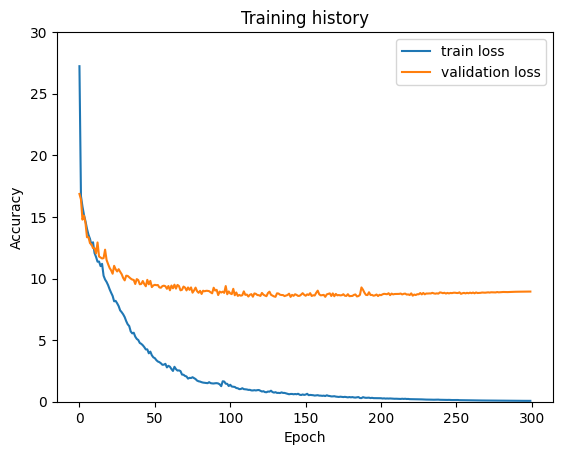

In [ ]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["valid_loss"], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);
print(best_valid_loss)

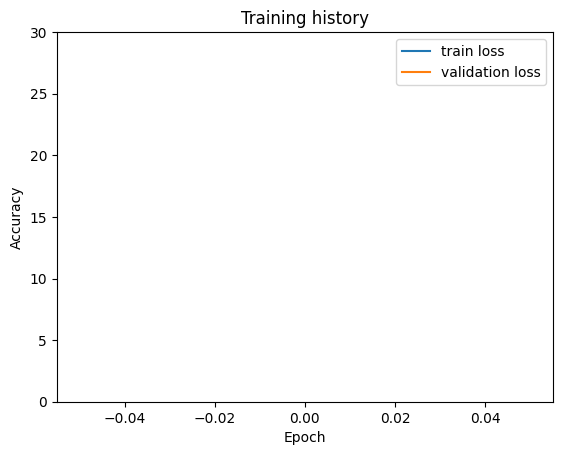

In [ ]:
#Plot training and validation accuracy
plt.plot(history["train_loss"][2000:2500], label='train loss')
plt.plot(history["valid_loss"][2000:2500], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);

In [ ]:
def prevision_mocap(model, input_mocap, device, max_output_length):
    model.eval()
    with torch.no_grad():
        input_mocap = torch.tensor(input_mocap).float().to(device)
        # input_mocap = [50, 57]
        input_mocap = input_mocap.unsqueeze(1)
        # input_mocap = [50, 1, 57]
        
        hidden, cell = model.encoder(input_mocap)
        # input_mocap = [1, 1, hidden_dim]
        # input_mocap = [1, 1, hidden_dim]

        input_mocap = input_mocap.squeeze(1)
        # input_mocap = [50, 57]
        previsions = [input_mocap[-1].tolist()]

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor([previsions[-1]]).to(device)

            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            # output = [1, 57]
            output = output.tolist()
            previsions.append(output[0])
    
    del previsions[0]
    return np.array(previsions)


In [ ]:
rand_x = random.randint(0, len(frame_vocab_copy))

input_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][:50])

deleted = input_mocap[:, indexes_to_exclude]

input_mocap_test = np.delete(input_mocap, indexes_to_exclude, axis=1)

expected_output_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][-25:])

prevision = prevision_mocap(
    model,
    input_mocap_test,
    device,
    max_output_length = expected_output_mocap.shape[0]
)

for i, column in enumerate(deleted[-25:].T):
    prevision = np.insert(prevision, indexes_to_exclude[i], column, axis=1)

input_mocap = input_mocap.reshape(50, 24, 3)
print(input_mocap.shape)

expected_output_mocap = expected_output_mocap.reshape(25, 24, 3)
print(expected_output_mocap.shape)

prevision = prevision.reshape(25, 24, 3)
print(prevision.shape)

(50, 24, 3)
(25, 24, 3)
(25, 24, 3)


In [ ]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 57
75 72


In [ ]:

input_mocap = kine.compute_fk(input_mocap, apply_root_rotation=True)
expected_output_mocap = kine.compute_fk(expected_output_mocap, apply_root_rotation=True)
prevision = kine.compute_fk(prevision, apply_root_rotation=True)

motions_list = [[input_mocap], [expected_output_mocap, prevision]]
subplot_ids = [[0], [0,1]]
subplot_titles = [['Input_mocap'], ['Expected_output_mocap', 'Prevision']]
camera_orientations = [[CameraOrientation(100, 20)], [CameraOrientation(100, 20), CameraOrientation(100, 20)]]

pose_animation(motions_list[0], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[0], 
               camera_orientations=camera_orientations[0], subplot_titles=subplot_titles[0],
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

pose_animation(motions_list[1], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[1], 
               camera_orientations=camera_orientations[1], subplot_titles=subplot_titles[1],
               animation_mode=AnimationMode.HTML)